In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM, GRU, Input, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *

In [31]:
# Carregar dados
data = pd.read_csv("C:\\Users\\heito\\Documents\\eps\\newData\\new_dataUSD_CAD_H1.csv", parse_dates=['time'])
data = data.drop(columns=['bid_o', 'bid_h', 'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c', 'mid_o', 'mid_h', 'mid_l', 'volume'])
# fiter data to above 2022
data = data[data['time'] > '2023-01-01'] 
data

,time,mid_c,EMA_12,EMA_26,SMA_20,WMA_20,HMA_20,MACD,TypicalPrice,CCI,StochasticOscillator,RSI,ROC,PPO,KST,BollingerBandUp,BollingerBandMiddle,BollingerBandDown
43478,2023-01-01 23:00:00+00:00,1.35342,1.354027,1.354504,1.354180,1.353985,1.353953,-0.000477,1.354123,-29.444152,29.705882,44.825991,-0.137241,-0.035234,-1.953081,1.356998,1.354326,1.351654
43479,2023-01-02 00:00:00+00:00,1.35256,1.353801,1.354360,1.354044,1.353830,1.353821,-0.000559,1.352810,-119.892975,17.058824,39.515879,-0.190386,-0.041267,-1.879702,1.356891,1.354218,1.351546
43480,2023-01-02 01:00:00+00:00,1.35281,1.353649,1.354245,1.353927,1.353713,1.353599,-0.000597,1.352877,-103.452562,20.735294,41.827317,-0.151307,-0.044052,-1.822350,1.356764,1.354092,1.351420
43481,2023-01-02 02:00:00+00:00,1.35597,1.354006,1.354373,1.353983,1.353907,1.353678,-0.000367,1.354987,58.033474,62.331081,62.646610,0.070110,-0.027112,-1.743420,1.356774,1.354102,1.351430
43482,2023-01-02 03:00:00+00:00,1.35483,1.354133,1.354407,1.353973,1.353988,1.353885,-0.000274,1.355353,76.462941,41.493056,54.523924,-0.031728,-0.020249,-1.635514,1.356793,1.354121,1.351448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52689,2024-06-24 19:00:00+00:00,1.36546,1.366593,1.367636,1.367747,1.366899,1.365351,-0.001042,1.365357,-80.378358,10.791367,30.640910,-0.316835,-0.076214,-1.181163,1.370497,1.367825,1.365153
52690,2024-06-24 20:00:00+00:00,1.36578,1.366468,1.367498,1.367546,1.366711,1.365183,-0.001030,1.365730,-59.626885,19.896641,36.538017,-0.326945,-0.075319,-1.359046,1.370286,1.367614,1.364942
52691,2024-06-24 21:00:00+00:00,1.36586,1.366375,1.367377,1.367326,1.366551,1.365091,-0.001002,1.365880,-51.004623,21.963824,38.057215,-0.290545,-0.073294,-1.543086,1.370067,1.367395,1.364722
52692,2024-06-24 22:00:00+00:00,1.36580,1.366286,1.367260,1.367125,1.366405,1.365075,-0.000974,1.365713,-55.594875,20.413437,37.284816,-0.283278,-0.071222,-1.720784,1.369854,1.367182,1.364510


In [32]:
# Criar a coluna target (1 se subir, 0 se descer)
data['Target'] = (data['mid_c'].shift(-1) > data['mid_c']).astype(int)

# Remover valores NaN
data.dropna(inplace=True)

# Seleção de Features (usando todas as colunas menos a data e a target)
features = data.drop(columns=['time', 'Target'])

# Normalizar/Padronizar os dados
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [33]:
# Definir o tamanho da janela
window_size = 10

# Criar sequências de janelas deslizantes
def create_sequences(features, target, window_size):
    X = []
    y = []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])
        y.append(target[i + window_size])   
    return np.array(X), np.array(y)

X, y = create_sequences(features_scaled, data['Target'].values, window_size)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)


In [34]:
import datetime

epochs = 100

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=np.max([epochs/2, 30]),         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # File path to save the model
    monitor='val_loss',        # Monitor validation loss
    save_best_only=True        # Save the model only when the monitored metric improves
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=int(epochs/5),
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0000001
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensor_board = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [4]:
# X_train, X_test, y_train, y_test = train_test_split(features_scaled, data['Target'].values, test_size=0.2, shuffle=False)

In [35]:
data['Target'].value_counts()

Target
0    4620
1    4596
Name: count, dtype: int64

In [36]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7364, 1842, 7364, 1842)

In [32]:
# Criar o modelo CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/200


/home/hmsb/neuraltrade-backend/.conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4991 - loss: 0.7056 - val_accuracy: 0.4925 - val_loss: 0.6941
Epoch 2/200
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5042 - loss: 0.6936 - val_accuracy: 0.4873 - val_loss: 0.6935
Epoch 3/200
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5008 - loss: 0.6930 - val_accuracy: 0.4901 - val_loss: 0.6955
Epoch 4/200
207/310 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5056 - loss: 0.6919

KeyboardInterrupt: 

In [37]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window_size, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
# model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
# opt = Adam(learning_rate=0.01, decay=1e-3 /200)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [model_checkpoint, tensor_board]

history  = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
231/231 [==============================] - 12s 20ms/step - loss: 0.6984 - accuracy: 0.5008 - val_loss: 0.6946 - val_accuracy: 0.4913
Epoch 2/100
231/231 [==============================] - 4s 17ms/step - loss: 0.6965 - accuracy: 0.4891 - val_loss: 0.6984 - val_accuracy: 0.4940
Epoch 3/100
231/231 [==============================] - 3s 13ms/step - loss: 0.6950 - accuracy: 0.4962 - val_loss: 0.6947 - val_accuracy: 0.4929
Epoch 4/100
231/231 [==============================] - 3s 12ms/step - loss: 0.6946 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5065
Epoch 5/100
231/231 [==============================] - 3s 12ms/step - loss: 0.6942 - accuracy: 0.4973 - val_loss: 0.6963 - val_accuracy: 0.4875
Epoch 6/100
231/231 [==============================] - 3s 12ms/step - loss: 0.6943 - accuracy: 0.5005 - val_loss: 0.6944 - val_accuracy: 0.5011
Epoch 7/100
231/231 [==============================] - 3s 12ms/step - loss: 0.6937 - accuracy: 0.4973 - val_loss: 0.6961 - val_accuracy

In [42]:
best_model = tf.keras.models.load_model('best_model.h5')

# save model
model.save('model.h5')

58/58 [==============================] - 0s 7ms/step - loss: 2.0061 - accuracy: 0.4870
Acurácia: 0.4869706928730011
58/58 [==============================] - 0s 8ms/step
9206
1842


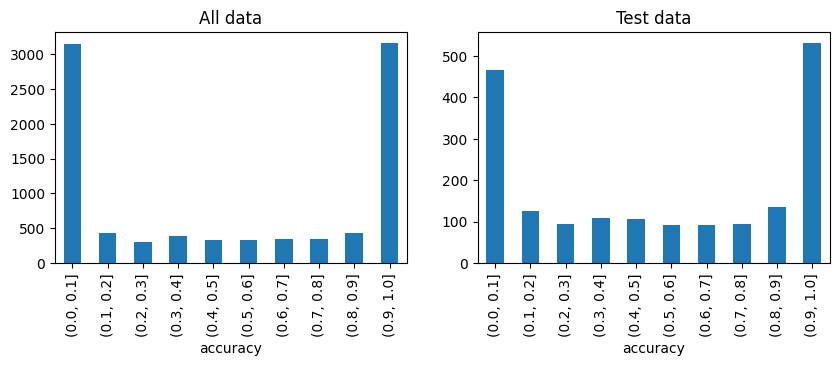

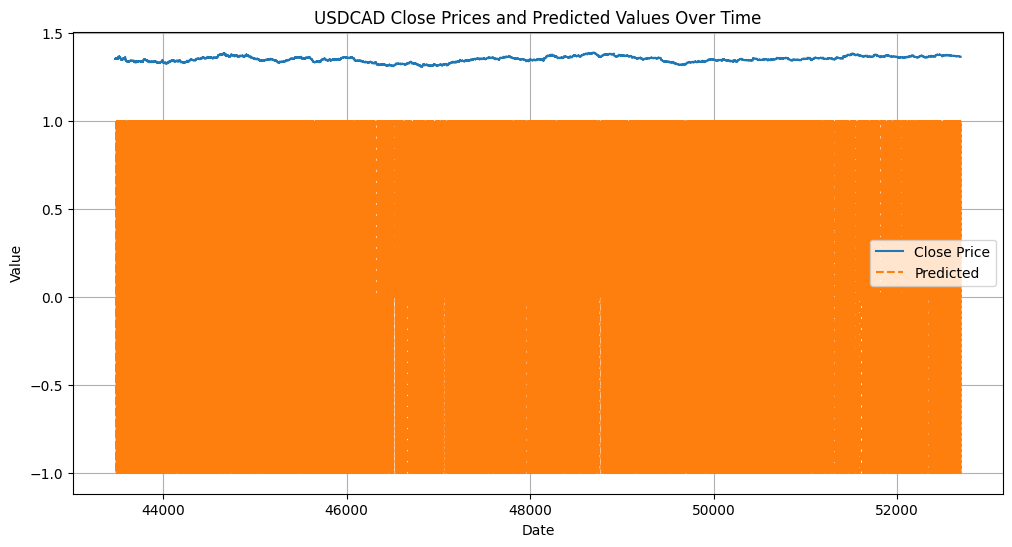

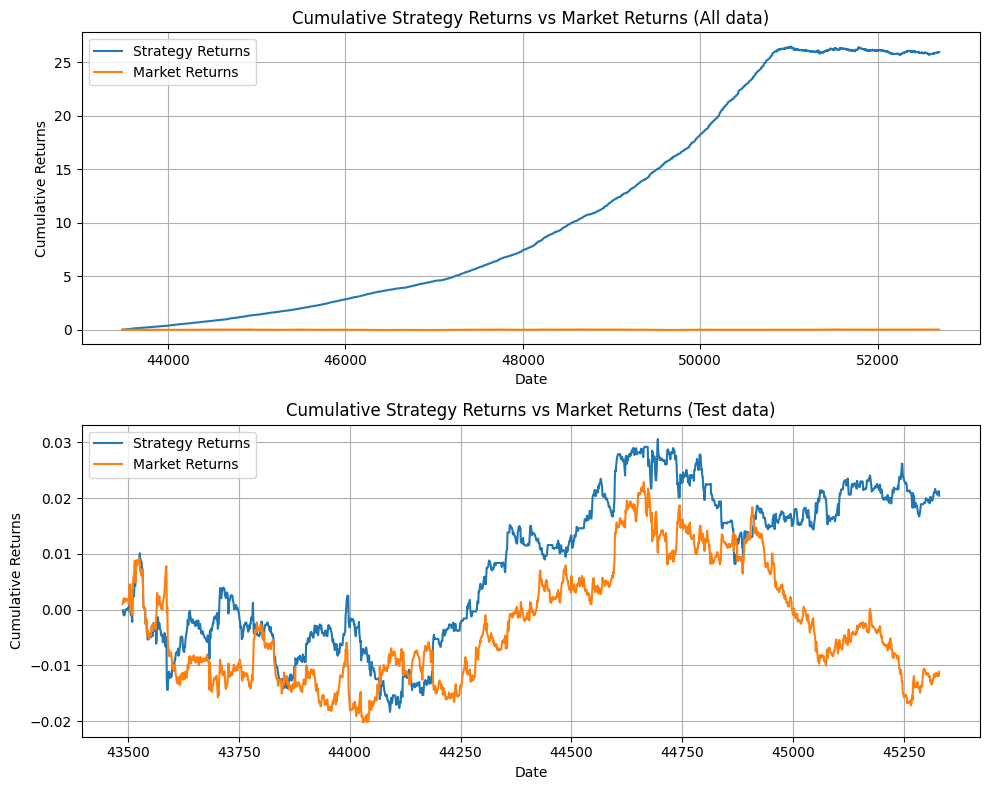

Diferença percentual dos retornos cumulativos (Treino): 2594.05%
Diferença percentual dos retornos cumulativos (Teste): 3.16%


In [41]:
avalia_modelo(model, X_test, y_test)
predictions_all, predictions_test = create_predicted_table(model, X_train, X_test, data, window_size)
plot_predictions(predictions_all, predictions_test)
plot_predictions_and_prices(data, predictions_all)
predictions_all, predictions_test = get_returns(predictions_all, predictions_test, data)
plot_returns(predictions_all, predictions_test)
return_diff_all, return_diff_test = calculate_return_difference(predictions_all, predictions_test)
print(f'Diferença percentual dos retornos cumulativos (Treino): {return_diff_all:.2f}%')
print(f'Diferença percentual dos retornos cumulativos (Teste): {return_diff_test:.2f}%')

In [10]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


/home/hmsb/neuraltrade-backend/.conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4928 - loss: 0.6971 - val_accuracy: 0.4857 - val_loss: 0.6947
Epoch 2/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4973 - loss: 0.6938 - val_accuracy: 0.4954 - val_loss: 0.6938
Epoch 3/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4997 - loss: 0.6936 - val_accuracy: 0.4958 - val_loss: 0.6939
Epoch 4/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.4938 - val_loss: 0.6939
Epoch 5/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.4942 - val_loss: 0.6940
Epoch 6/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5172 - loss: 0.6929 - val_accuracy: 0.5046 - val_loss: 0.6938
Epoch 7/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5070 - loss: 0.6928 - val_accuracy: 0.4877 - val_loss: 0.6946
Epoch 8/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5109 - loss: 0.6927 - val_accuracy: 0.4857

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5134 - loss: 2.7954
Acurácia: 0.511084258556366
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
12402
2481


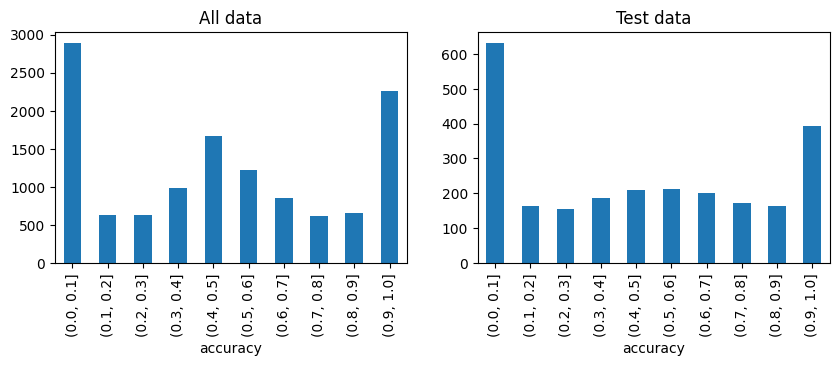

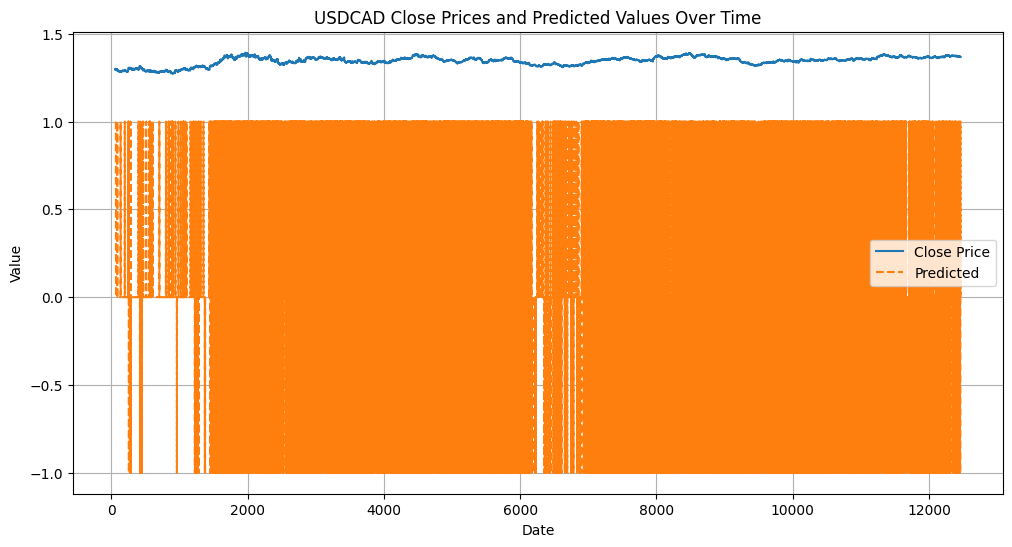

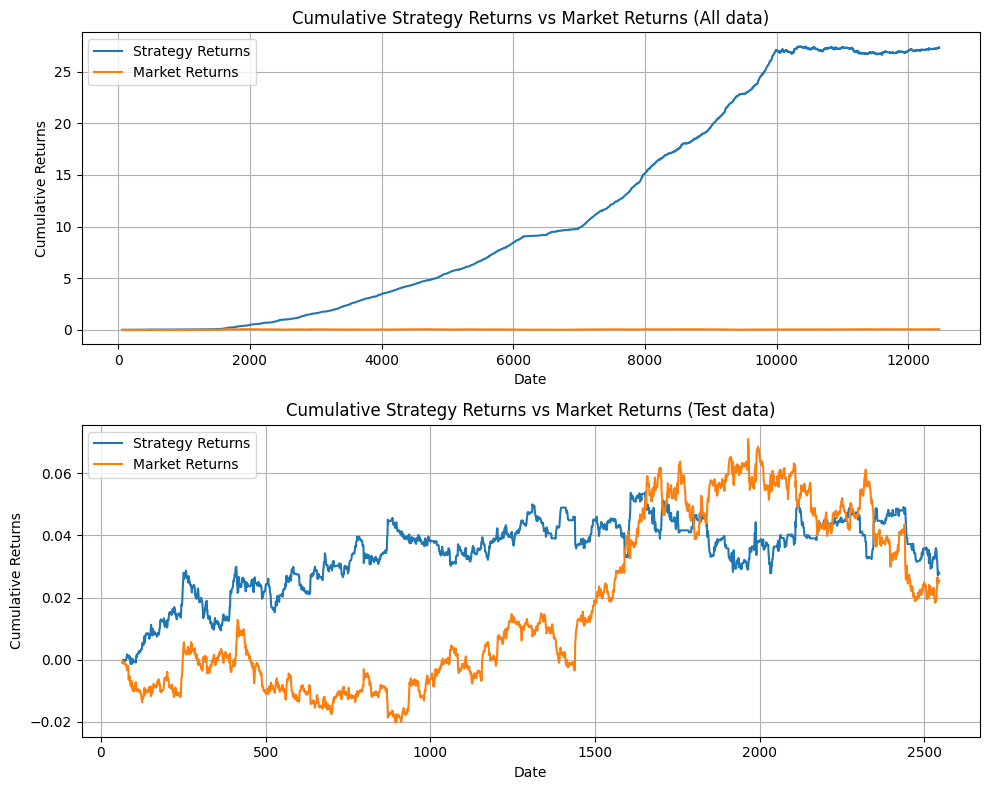

Diferença percentual dos retornos cumulativos (Treino): 2726.33%
Diferença percentual dos retornos cumulativos (Teste): 0.25%


In [11]:
avalia_modelo(model, X_test, y_test)
predictions_all, predictions_test = create_predicted_table(model, X_train, X_test, data, window_size)
plot_predictions(predictions_all, predictions_test)
plot_predictions_and_prices(data, predictions_all)
predictions_all, predictions_test = get_returns(predictions_all, predictions_test, data)
plot_returns(predictions_all, predictions_test)
return_diff_all, return_diff_test = calculate_return_difference(predictions_all, predictions_test)
print(f'Diferença percentual dos retornos cumulativos (Treino): {return_diff_all:.2f}%')
print(f'Diferença percentual dos retornos cumulativos (Teste): {return_diff_test:.2f}%')

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'C': [0.1, 1, 10, 100],      # valores do parâmetro C
#     'gamma': ['scale', 'auto'],  # valores do parâmetro gamma
#     'kernel': ['linear', 'rbf']  # tipos de kernel
# }
param_grid = {
    'C': [1],      # valores do parâmetro C
    'gamma': ['auto'],  # valores do parâmetro gamma
    'kernel': ['rbf']  # tipos de kernel
}

# Transforme seus dados de treinamento e teste em um formato adequado para a SVM
X_train_svm = X_train.reshape(X_train.shape[0], -1)
X_test_svm = X_test.reshape(X_test.shape[0], -1)


svm_model = SVC()
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_svm, y_train)

best_params = grid_search.best_params_
print("Melhores parâmetros:", best_params)

# Faça previsões com o modelo usando os melhores parâmetros
svm_model = grid_search.best_estimator_
y_pred = svm_model.predict(X_test_svm)

# Avalie a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Inicialize o modelo SVM
# svm_model = SVC(kernel='rbf', gamma='scale')
# Treine o modelo SVM
# svm_model.fit(X_train_svm, y_train)

Melhores parâmetros: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.4772269246271665


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Faça previsões nos dados de teste
y_pred = svm_model.predict(X_test_svm)

# Calcule as métricas de desempenho
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.4772269246271665
Precision: 0.4581901489117984
Recall: 0.32679738562091504
F1-score: 0.38149737720553173
Confusion Matrix:
[[784 473]
 [824 400]]


12402
2481


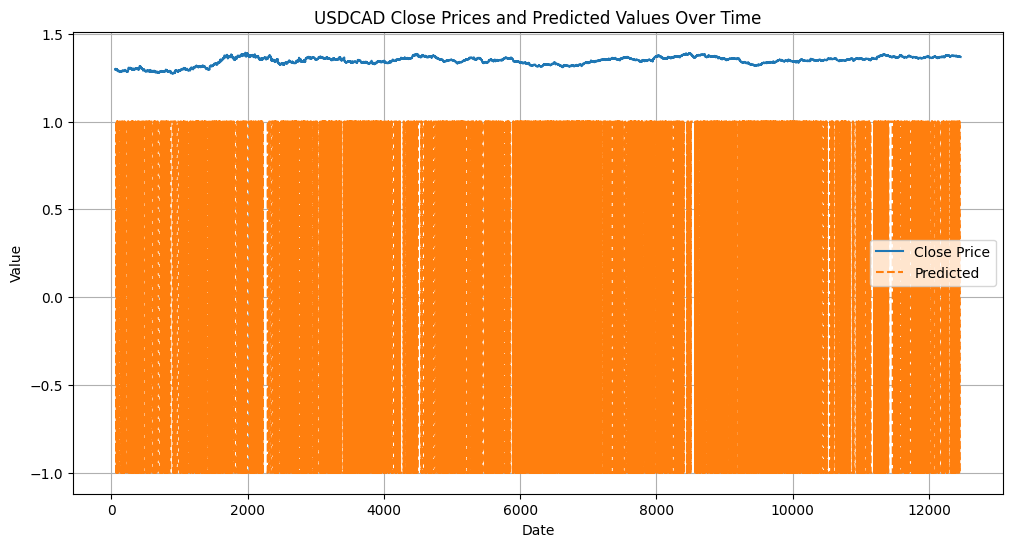

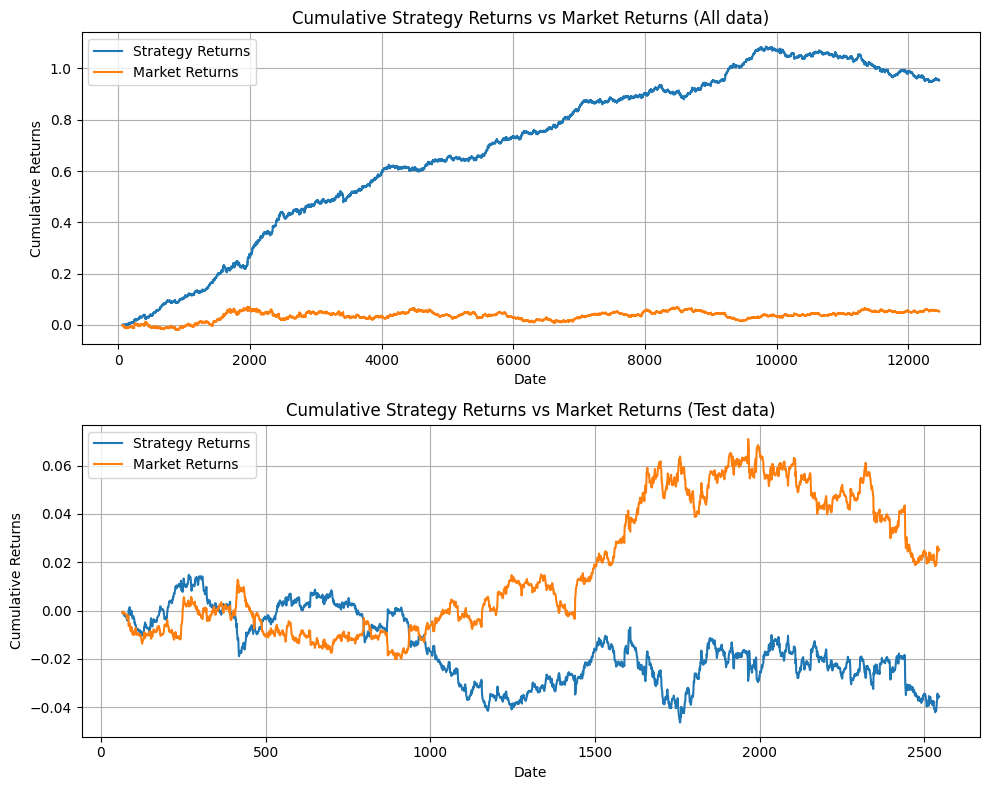

Diferença percentual dos retornos cumulativos (Treino): 90.10%
Diferença percentual dos retornos cumulativos (Teste): -6.09%


In [14]:
predictions_all, predictions_test = create_predicted_table(svm_model, X_train_svm, X_test_svm, data, window_size)
plot_predictions_and_prices(data, predictions_all)
predictions_all, predictions_test = get_returns(predictions_all, predictions_test, data)
plot_returns(predictions_all, predictions_test)
return_diff_all, return_diff_test = calculate_return_difference(predictions_all, predictions_test)
print(f'Diferença percentual dos retornos cumulativos (Treino): {return_diff_all:.2f}%')
print(f'Diferença percentual dos retornos cumulativos (Teste): {return_diff_test:.2f}%')